Edited by Mohamed Sayed on 27/11/2019. All errors are now my own.
# Practical 7 - Part 1A

The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TODO"


## Import libraries 

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio


## Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [3]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom)

# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1))

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 2.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

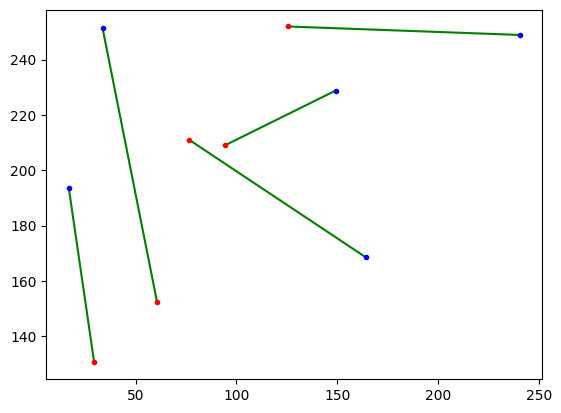

In [4]:
# Plot a green line between pairs of start points (blue) and transformed points (red).|
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

The plot above shows the starting points(blue) and the transformed points(red).

## Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TODO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [5]:
def solveAXEqualsZero(A):
    # TODO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes!
    # Hint: SVD will be involved.

    # Perform Singular Value Decomposition
    U, S, V = np.linalg.svd(A)
    
    # The solution to Ah = 0 is the last column of V (or last row of V transposed, V_t)
    h = (V.T)[:, -1]
    
    return h

In [6]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    
    # Construct matrix A (size: n_points * 2 , 9)
    A = np.zeros((n_points * 2, 9))

    u = pts1Hom[0,:]
    v = pts1Hom[1,:]
    x = pts2Cart[0,:]
    y = pts2Cart[1,:]

    for i in range (n_points):
        A[2*i] = np.array([0,0,0,-1*u[i], -1*v[i], -1, y[i]*u[i], y[i]*v[i], y[i]])
        A[2*i+1] = np.array([u[i], v[i], 1, 0, 0, 0, -1*x[i]*u[i], -1*x[i]*v[i], -1*x[i]])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h= solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape((3,3))
    
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Squared difference between pts2Cart and pts2EstCart is: 0.71


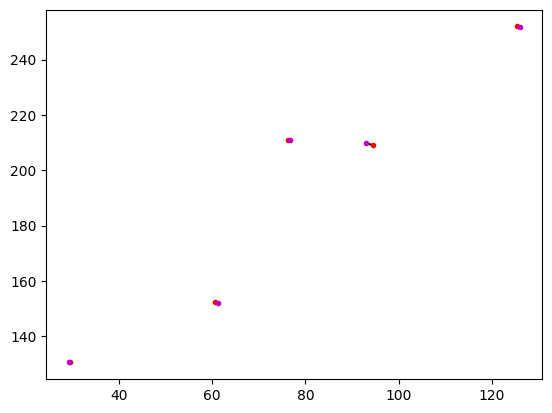

In [7]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
HEst = calcBestHomography(pts1Cart, pts2Cart)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Squared difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

The plot above illustrates the differences between pairs of actual points and estimated points. The black line represents the distance between the estimated points (obtained by applying the estimated homography) and the ground truth points (calculated using the true homography). The optimal estimated homography matrix is determined by solving the equation "Ah=0". In this example, the noise level is set to 2.0. When the noise level is 0, the actual points and predicted points coincide.

## Other things **** TODO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

## Q1.
If we multiply a constant factor k, we will have
$$ \lambda \begin{bmatrix}
x_i \\
y_i \\
1 \\
\end{bmatrix} \times k = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{31} & \phi_{32} & \phi_{33} \\
\end{bmatrix} 
\begin{bmatrix}
u_i \\
v_i \\
1 \\
\end{bmatrix} = 
k \begin{bmatrix}
\phi_{11} & \phi_{12} & \phi_{13} \\
\phi_{21} & \phi_{22} & \phi_{23} \\
\phi_{31} & \phi_{32} & \phi_{33} \\
\end{bmatrix} 
\begin{bmatrix}
u_i \\
v_i \\
1 \\
\end{bmatrix} $$ 

This means that all the resulting coordinates are scaled by k. since we use homogeneous coordinates. Then as we converted back from homogeneous to cartesian coordinates. This will cancel out the scaling factor k. Hence, the result is identical to using the original homography matrix H. Therefore we can conclude that the homography is scale-insensitive.

## Q2.

The homography is a 3x3 matrix and the last entry is 1 (By normalisation). There are 8 unknown entries in this matrix (8 degree of freedom). We have any four points and then can construct 8 equations to get the 8 unknown entries to solve Ah=0. Therefore, our homography routine can exactly map any four points to any other four points.

$$ \begin{bmatrix}
0 & 0 & 0 & -u_1 & -v_1 & -1 & y_1 u_1 & y_1 v_1 & y_1 \\
u_1 & v_1 & 1 & 0 & 0 & 0 & -x_1 u_1 & -x_1 v_1 & -x_1 \\ 
0 & 0 & 0 & -u_2 & -v_2 & -1 & y_2 u_2 & y_2 v_2 & y_2 \\
u_2 & v_2 & 1 & 0 & 0 & 0 & -x_2 u_2 & -x_2 v_2 & -x_2 \\
0 & 0 & 0 & -u_3 & -v_3 & -1 & y_3 u_3 & y_3 v_3 & y_3 \\
u_3 & v_3 & 1 & 0 & 0 & 0 & -x_3 u_3 & -x_3 v_3 & -x_3 \\ 
0 & 0 & 0 & -u_4 & -v_4 & -1 & y_4 u_4 & y_4 v_4 & y_4 \\   
u_4 & v_4 & 1 & 0 & 0 & 0 & -x_4 u_4 & -x_4 v_4 & -x_4 \\ 
\end{bmatrix} \begin{bmatrix}
\phi_{11} \\
\phi_{12} \\
\phi_{13} \\
\phi_{21} \\
\phi_{22} \\
\phi_{23} \\
\phi_{31} \\
\phi_{32} \\
\phi_{33}
\end{bmatrix} = \begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}
$$
